In [1]:
import pandas as pd
import numpy as np

/home/donatien/anaconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
clean_data = "../data/clean_modeling_data.csv"
data = pd.read_csv(clean_data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25832 entries, 0 to 25831
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      25832 non-null  object
 1   publishedAt  25832 non-null  object
dtypes: object(2)
memory usage: 403.8+ KB


In [3]:
docs = data['comment']

# Topic modeling with BERTopic

## Embeddings

In [4]:
from sentence_transformers import SentenceTransformer

/home/donatien/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-25 10:53:55.121344: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 10:53:55.123831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 10:53:55.172606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriat

In [5]:
model = "sentence-transformers/all-MiniLM-L6-v2"
device = "cpu"
embedding_model = SentenceTransformer(model, device=device)

/home/donatien/anaconda3/envs/tf/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches: 100%|██████████| 808/808 [04:02<00:00,  3.33it/s]


In [ ]:
with open('./saved/saved_embeddings.npy', 'wb') as f:
    pass#np.save(f, embeddings)

In [ ]:
#embeddings = np.load("./saved/saved_embeddings.npy")

## WordCloud

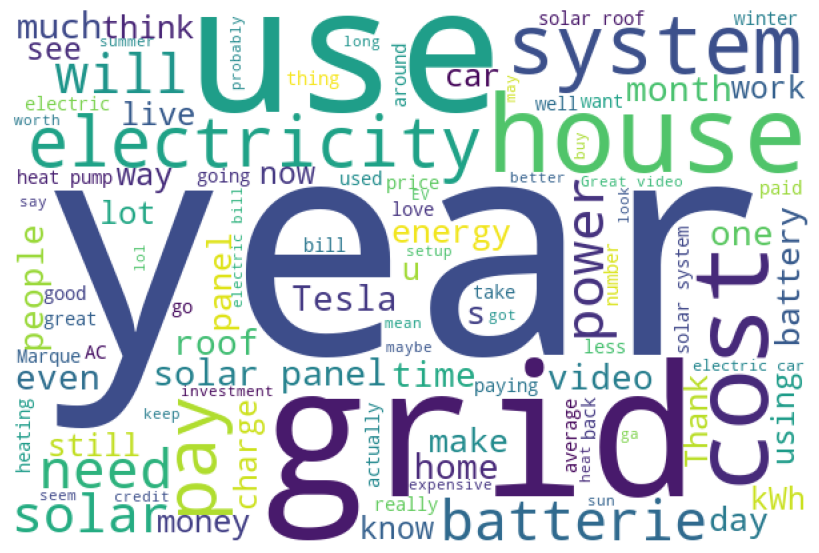

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = ' '.join(docs)

wordcloud = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Vocabulary preparation

In [9]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Step 1: Get the stopwords
stop_words = set(stopwords.words("english"))  # We use a set for faster lookups


# Step 2: Tokenize and build the vocabulary
all_vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
    tokens = tokenizer(doc)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    all_vocab.update(filtered_tokens)

100%|██████████| 25832/25832 [00:00<00:00, 94594.46it/s]


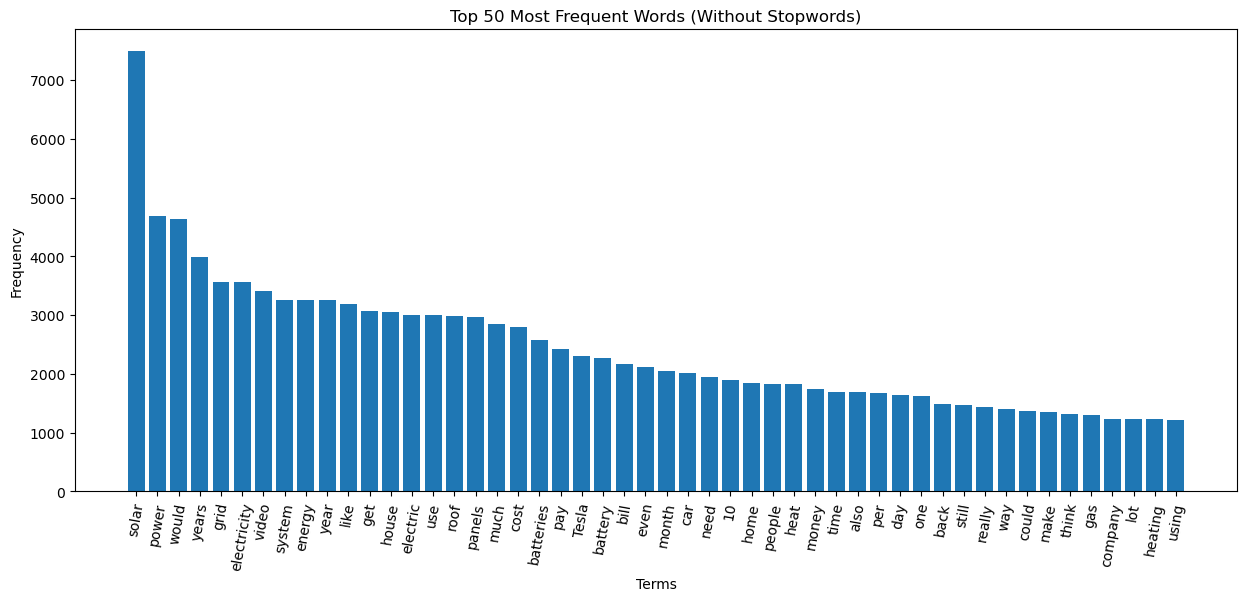

In [10]:
import matplotlib.pyplot as plt

top_n = 50
most_common_words = all_vocab.most_common(top_n)

# Separate the words and their frequencies
words, frequencies = zip(*most_common_words)

# Create a bar plot

plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top ' + str(top_n) + ' Most Frequent Words (Without Stopwords)')
plt.xticks(rotation=80)
plt.show()

In [ ]:
#vocab = [word for word, frequency in all_vocab.items() if frequency >= 15]

## Modeling

In [11]:
from umap import UMAP
import hdbscan
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

In [13]:
# Emdedding
embedding_model = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2", device="cpu"
)
# UMAP
umap_model = UMAP(
    n_components=10,
    n_neighbors=15,
    random_state=42,
    metric="cosine",
    min_dist=0.0,
    low_memory=False,
    verbose=True,
)
# HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(
    prediction_data=True,
    min_cluster_size=30,
    min_samples=25,
    metric="euclidean",
    cluster_selection_method="eom",
    gen_min_span_tree=True,
)
# Vectorizer
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=list(stop_words),
)

# Additional Representations

#keybert_model = KeyBERTInspired()
# mmr_model = MaximalMarginalRelevance(diversity=0.3)
# pos_model = PartOfSpeech("en_core_web_sm")
#representation_model = {"KeyBERT": keybert_model}


# BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    #representation_model=representation_model,
    min_topic_size=80,
    verbose=True,
)

In [14]:
topic_model.fit(docs,embeddings=embeddings)

2024-11-25 11:00:45,295 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=10, n_jobs=1, random_state=42, verbose=True)
Mon Nov 25 11:00:45 2024 Construct fuzzy simplicial set
Mon Nov 25 11:00:45 2024 Finding Nearest Neighbors
Mon Nov 25 11:00:45 2024 Building RP forest with 13 trees
Mon Nov 25 11:00:47 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	Stopping threshold met -- exiting after 7 iterations
Mon Nov 25 11:00:57 2024 Finished Nearest Neighbor Search
Mon Nov 25 11:00:59 2024 Construct embedding


Epochs completed:   4%| ▎          7/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▎         25/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▎        45/200 [00:03]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▎       65/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▎      85/200 [00:06]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▎     105/200 [00:07]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▎    125/200 [00:08]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▎   145/200 [00:10]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▎  165/200 [00:12]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▎ 185/200 [00:13]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:14]
2024-11-25 11:01:14,665 - BERTopic - Dimensionality - Completed ✓
2024-11-25 11:01:14,666 - BERTopic - Cluster - Start clustering the reduced embeddings


Mon Nov 25 11:01:14 2024 Finished embedding


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [15]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0       -1   9578                         -1_solar_years_would_power   
1        0   1552                      0_heat_pump_heat pump_heating   
2        1   1283                                  1_kwh_use_day_per   
3        2    581                           2_solar_bill_system_cost   
4        3    477                           3_grid_company_back_sell   
..     ...    ...                                                ...   
108    107     33                    107_car_cars_solar panels_solar   
109    108     33      108_solar_solar future_argument_argument make   
110    109     30    109_square_square footage_footage_footage house   
111    110     30  110_brownlee_marques brownlee_brown_markass br...   
112    111     30              111_comment_comments_likes_commenting   

                                        Representation  \
0    [solar, years, would, power, grid, batteries, ...   
1    [heat, pump, heat pump, heating, gas, ac, air,...   
2    [kwh, use, day, per, month, year, usage, consu...   
3    [solar, bill, system, cost, years, panels, sol...   
4    [grid, company, back, sell, back grid, credits...   
..                                                 ...   
108  [car, cars, solar panels, solar, car solar, pa...   
109  [solar, solar future, argument, argument make,...   
110  [square, square footage, footage, footage hous...   
111  [brownlee, marques brownlee, brown, markass br...   
112  [comment, comments, likes, commenting, algorit...   

                                   Representative_Docs  
0    [Hey - I guessed peak solar month either May o...  
1    [You can heat up your house with a heat pump.....  
2    [How can you use 6,500 kWh in one month. If yo...  
3    [Your math is wrong. You're closer to 20 year ...  
4    [The electric company should pay you when you ...  
..                                                 ...  
108  [29:30 It’s not going to be a solar array and ...  
109  [OK… I’m 60, a Dad and you drop a super tight ...  
110  [What is your square footage of the house. Or ...  
111  [Markass brownlee, Marques Brownlee, Mark ass ...  
112  [Theres always one annoying patronising little...  

[113 rows x 5 columns]

In [16]:
topic_model.get_topic(topic=0,full=True)

{'Main': [('heat', 0.03732508858949975),
  ('pump', 0.025637204951688246),
  ('heat pump', 0.025605613089161056),
  ('heating', 0.02455501734586382),
  ('gas', 0.01768787733622884),
  ('ac', 0.015950002574500285),
  ('air', 0.015510305135925707),
  ('pumps', 0.013319849867511299),
  ('heat pumps', 0.013274704565509082),
  ('water', 0.011062208639224802)]}

In [26]:
topic_model.get_topic(topic=27)

[('rich', 0.1008054527349523),
 ('rich people', 0.04041744332260863),
 ('money', 0.03826931806659728),
 ('people', 0.03067017754716625),
 ('afford', 0.02442449537527711),
 ('poor', 0.01996327454319791),
 ('richer', 0.01849895669836371),
 ('things', 0.018096545223450895),
 ('must', 0.01649033295150439),
 ('millionaire', 0.015625528794792308)]

In [29]:
topic_model.get_topic(topic=27)

[('rich', 0.1008054527349523),
 ('rich people', 0.04041744332260863),
 ('money', 0.03826931806659728),
 ('people', 0.03067017754716625),
 ('afford', 0.02442449537527711),
 ('poor', 0.01996327454319791),
 ('richer', 0.01849895669836371),
 ('things', 0.018096545223450895),
 ('must', 0.01649033295150439),
 ('millionaire', 0.015625528794792308)]

## Topics visualization 

In [34]:
topic_model.visualize_barchart(top_n_topics=16, n_words=8)

In [31]:
topic_model.visualize_topics()

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def get_topic_keywords(topic_id):
    topic = topic_model.get_topic(topic_id)
    if not topic:
        return []
    return [keyword for keyword, _ in topic]

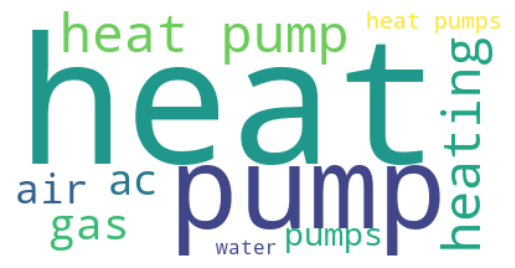

In [243]:
# Show wordcloud
create_wordcloud(topic_model, topic=0)

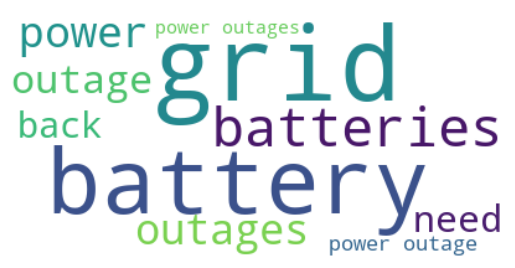

In [23]:
create_wordcloud(topic_model, topic=33)

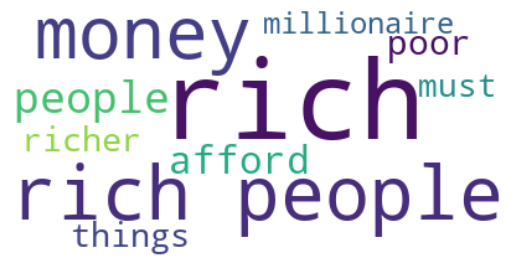

In [27]:
create_wordcloud(topic_model, topic=27)

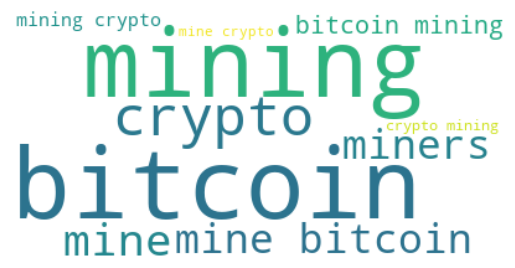

In [30]:
create_wordcloud(topic_model, topic=32)

In [35]:
dates = data["publishedAt"]
topics_over_time = topic_model.topics_over_time(docs, dates, nr_bins=20)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [00:17,  1.14it/s]


## Visualize Documents

In [36]:
reduced_embeddings= UMAP(
    n_components=2,
    n_neighbors=15,
    random_state=42,
    metric="cosine",
    min_dist=0.0,
    low_memory=False,
).fit_transform(embeddings)

In [37]:
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, hide_annotations=True)

In [38]:
topic_model.save(
    path='./saved/BERTopic_tesla_sr',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model=True,
)